In [71]:
import pyglet
pyglet.options['shadow_window'] = False
import os
import numpy as np
import trimesh
import pyrr

from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     Viewer, OffscreenRenderer, RenderFlags

# Mesh Creating

### Creating textured meshes from trimeshes

In [72]:
# Fuze trimesh
fuze_trimesh = trimesh.load('./models/fuze.obj')
fuze_mesh = Mesh.from_trimesh(fuze_trimesh)

# Drill trimesh
drill_trimesh = trimesh.load('./models/drill.obj')
drill_mesh = Mesh.from_trimesh(drill_trimesh)
drill_pose = np.eye(4)
drill_pose[0,3] = 0.1
drill_pose[2,3] = -np.min(drill_trimesh.vertices[:,2])

# Wood trimesh
wood_trimesh = trimesh.load('./models/wood.obj')
wood_mesh = Mesh.from_trimesh(wood_trimesh)

# Water bottle trimesh
bottle_gltf = trimesh.load('./models/WaterBottle.glb')
bottle_trimesh = bottle_gltf.geometry[list(bottle_gltf.geometry.keys())[0]]
bottle_mesh = Mesh.from_trimesh(bottle_trimesh)
bottle_pose = np.array([
    [1.0, 0.0,  0.0, 0.1],
    [0.0, 0.0, -1.0, -0.16],
    [0.0, 1.0,  0.0, 0.13],
    [0.0, 0.0,  0.0, 1.0],
])

### Creating meshes with per-vertex colors

In [73]:
boxv_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
boxv_vertex_colors = np.random.uniform(size=(boxv_trimesh.vertices.shape))
boxv_trimesh.visual.vertex_colors = boxv_vertex_colors
boxv_mesh = Mesh.from_trimesh(boxv_trimesh, smooth=False)

### Creating meshes with per-face colors

In [74]:
boxf_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
boxf_face_colors = np.random.uniform(size=boxf_trimesh.faces.shape)
boxf_trimesh.visual.face_colors = boxf_face_colors
boxf_mesh = Mesh.from_trimesh(boxf_trimesh, smooth=False)

### Creating meshes from point clouds

In [75]:
points = trimesh.creation.icosphere(radius=0.05).vertices
point_colors = np.random.uniform(size=points.shape)
points_mesh = Mesh.from_points(points, colors=point_colors)

# Light creation

In [76]:
direc_l = DirectionalLight(color=np.ones(3), intensity=1.0)
spot_l = SpotLight(color=np.ones(3), intensity=10.0,
                   innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)
point_l = PointLight(color=np.ones(3), intensity=10.0)

# Camera creation

In [77]:
cam = PerspectiveCamera(yfov=(np.pi / 3.0),aspectRatio=1.414)
# cam_pose = np.array([
#     [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.5],
#     [1.0, 0.0,           0.0,           0.0],
#     [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
#     [0.0,  0.0,           0.0,          1.0]
# ])
cam_pose = pyrr.matrix44.create_look_at((0.5,0.0,0.4), (0,0,0), (0,0,1))
cam_pose = np.linalg.inv(cam_pose.T)
cam_pose

array([[ 0.        , -0.62469505,  0.78086881,  0.5       ],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.78086881,  0.62469505,  0.4       ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

# Scene creation

In [78]:
scene = Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))

# Adding objects to the scene

### By manually creating nodes

In [79]:
fuze_node = Node(mesh=fuze_mesh, translation=np.array([0.1, 0.15, -np.min(fuze_trimesh.vertices[:,2])]))
scene.add_node(fuze_node)
boxv_node = Node(mesh=boxv_mesh, translation=np.array([-0.1, 0.10, 0.05]))
scene.add_node(boxv_node)
boxf_node = Node(mesh=boxf_mesh, translation=np.array([-0.1, -0.10, 0.05]))
scene.add_node(boxf_node)

### By using the add() utility function

In [80]:
drill_node = scene.add(drill_mesh, pose=drill_pose)
bottle_node = scene.add(bottle_mesh, pose=bottle_pose)
wood_node = scene.add(wood_mesh)
direc_l_node = scene.add(direc_l, pose=cam_pose)
spot_l_node = scene.add(spot_l, pose=cam_pose)

# Using the viewer

### Using the viewer with a default camera

In [81]:
# v = Viewer(scene, shadows=True)

### Using the viewer with a pre-specified camera

In [82]:
cam_node = scene.add(cam, pose=cam_pose)
v = Viewer(scene, central_node=drill_node)



### Rendering offscreen from that camera

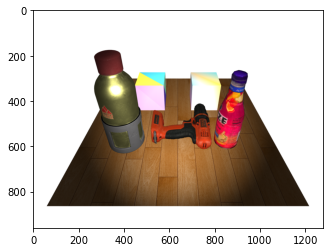

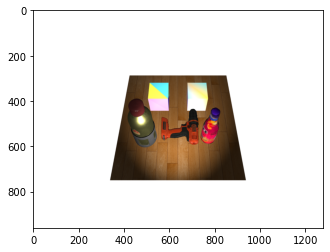

In [83]:

r = OffscreenRenderer(viewport_width=640*2, viewport_height=480*2)
color, depth = r.render(scene)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(color)
plt.show()


cam_pose = pyrr.matrix44.create_look_at(
    (0.5, 0, 0.8), (0, 0, 0), (0, 0, 1))
cam_pose = np.linalg.inv(cam_pose.T)
scene.set_pose(node = cam_node, pose=cam_pose)
color, depth = r.render(scene)

plt.figure()
plt.imshow(color)
plt.show()

### Segmask rendering

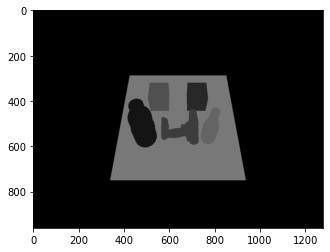

In [84]:
nm = {node: 20*(i + 1) for i, node in enumerate(scene.mesh_nodes)}
seg = r.render(scene, RenderFlags.SEG, nm)[0]
plt.figure()
plt.imshow(seg)
plt.show()

r.delete()